# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
model_path = "/gdrive/MyDrive/PPNCKH/saved/SST2/XLM-RoBERTa"

# Data downloader


In [3]:
!pip install tokenizers -q
!pip install transformers -q
!pip install datasets -q
!pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.5 MB/s eta 0:00:00


In [4]:
# Random
from transformers import set_seed
set_seed(42)

In [5]:
from datasets import load_dataset
from datasets import DatasetDict

train_dataset = load_dataset("sst2", split = "train")
test_dataset = load_dataset("sst2", split = "validation")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset sst2 downloaded and prepared to /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5. Subsequent calls will reuse this data.


Split the train into train and dev

In [6]:
train, dev = train_dataset.train_test_split(
    test_size = .3,
    seed = 42,
    stratify_by_column = "label"
).values()

In [7]:
train

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 47144
})

In [8]:
dev

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 20205
})

In [9]:
test_dataset

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 872
})

In [10]:
dataset = DatasetDict({
    "train" : train,
    "dev" : dev,
    "test" : test_dataset
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 47144
    })
    dev: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 20205
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})

In [12]:
num_labels = len(dataset["train"].features["label"].names)

In [13]:
num_labels

2

# Preprocessing

In [14]:
from transformers import AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast = True)

In [16]:
tokenizer(dataset["train"][0]["sentence"])

{'input_ids': [0, 187, 939, 136, 39644, 53, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [17]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation = True)

In [18]:
tokenized_dataset = dataset.map(preprocess_function, batched = True)

Map:   0%|          | 0/47144 [00:00<?, ? examples/s]

Map:   0%|          | 0/20205 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Rename the label column to fit the concept

In [19]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 47144
    })
    dev: Dataset({
        features: ['idx', 'sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 20205
    })
    test: Dataset({
        features: ['idx', 'sentence', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
})

# Finetuning XLM-roberta for text classification

In [21]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = num_labels)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [23]:
batch_size = 16
learning_rate = 2e-5
weight_decay = .01
num_train_epochs = 10
eval_steps = 500
logging_steps = len(tokenized_dataset["train"]) // batch_size
early_stopping_patience = 3

In [24]:
args = TrainingArguments(
    "/saved",
    evaluation_strategy = IntervalStrategy.STEPS,
    # save_strategy = IntervalStrategy.STEPS,

    eval_steps = eval_steps,
    logging_steps = logging_steps,
    
    learning_rate = learning_rate,
    
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    
    num_train_epochs = num_train_epochs,
    
    weight_decay = weight_decay,
    save_total_limit = 3,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    # report_to = "wandb"
)

In [25]:
import evaluate
import numpy as np

In [26]:
metric = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis = 1)

    return metric.compute(predictions = predictions, references = labels)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["dev"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = early_stopping_patience)]
)

## Training

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,No log,0.299637,0.881020
1000,No log,0.307752,0.889829
1500,No log,0.259111,0.905221
2000,No log,0.270470,0.910765
2500,No log,0.221471,0.917149
3000,0.327800,0.268907,0.924029


KeyboardInterrupt: ignored

In [ ]:
trainer.save_model(model_path)

# Evaluation

In [29]:
import torch

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels = num_labels).to(device)

Count parameters

In [32]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [33]:
count_parameters(model)

+------------------------------------------------------------+------------+
|                          Modules                           | Parameters |
+------------------------------------------------------------+------------+
|         roberta.embeddings.word_embeddings.weight          | 192001536  |
|       roberta.embeddings.position_embeddings.weight        |   394752   |
|      roberta.embeddings.token_type_embeddings.weight       |    768     |
|            roberta.embeddings.LayerNorm.weight             |    768     |
|             roberta.embeddings.LayerNorm.bias              |    768     |
|    roberta.encoder.layer.0.attention.self.query.weight     |   589824   |
|     roberta.encoder.layer.0.attention.self.query.bias      |    768     |
|     roberta.encoder.layer.0.attention.self.key.weight      |   589824   |
|      roberta.encoder.layer.0.attention.self.key.bias       |    768     |
|    roberta.encoder.layer.0.attention.self.value.weight     |   589824   |
|     robert

278045186

In [34]:
trainer.evaluate()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7041236758232117,
 'eval_accuracy': 0.44221727295223956,
 'eval_runtime': 46.8418,
 'eval_samples_per_second': 431.346,
 'eval_steps_per_second': 26.963}

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])

predictions = np.argmax(predictions, axis = 1)

Step,Training Loss,Validation Loss,Accuracy
500,No log,0.299637,0.881020
1000,No log,0.307752,0.889829
1500,No log,0.259111,0.905221
2000,No log,0.270470,0.910765
2500,No log,0.221471,0.917149
3000,0.327800,0.268907,0.924029
3017,0.327800,0.267303,0.927295


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       444
           1       0.89      0.93      0.91       428

    accuracy                           0.91       872
   macro avg       0.91      0.91      0.91       872
weighted avg       0.91      0.91      0.91       872



In [ ]:
print(f"Accuracy = {accuracy_score(predictions, labels):.6f}, \
        Precision = {precision_score(predictions, labels, average = 'macro'):.6f}, \
        Recall = {recall_score(predictions, labels, average = 'macro'):.6f}, \
        F1 = {f1_score(predictions, labels, average = 'macro'):.6f}")

Accuracy = 0.910550,         Precision = 0.910857,         Recall = 0.910857,         F1 = 0.910550


In [ ]:
print(confusion_matrix(predictions, labels))

[[397  47]
 [ 31 397]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

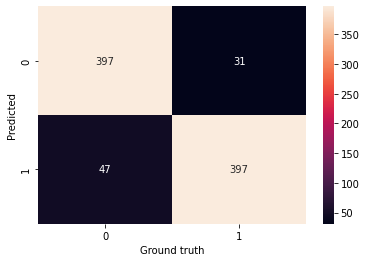

In [ ]:
sns.heatmap(confusion_matrix(labels, predictions), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, y_pred, y_truth in zip(tokenized_dataset["test"][0:10]["sentence"], predictions[0:10], labels[0:10]):
    print(f"{text} -- {y_pred} -- {y_truth}")

it 's a charming and often affecting journey .  -- 1 -- 1
unflinchingly bleak and desperate  -- 0 -- 0
allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  -- 1 -- 1
the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  -- 1 -- 1
it 's slow -- very , very slow .  -- 0 -- 0
although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  -- 1 -- 1
a sometimes tedious film .  -- 0 -- 0
or doing last year 's taxes with your ex-wife .  -- 0 -- 0
you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  -- 1 -- 1
in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey .  -- 0 -- 0


In [ ]:
for i in range(len(predictions)):
    if predictions[i] != labels[i]:
        print(tokenized_dataset["test"][i]["sentence"])
        print(f"Predicted: {predictions[i]} - Label: {labels[i]}")

we root for ( clara and paul ) , even like them , though perhaps it 's an emotion closer to pity . 
Predicted: 0 - Label: 1
holden caulfield did it better . 
Predicted: 1 - Label: 0
the primitive force of this film seems to bubble up from the vast collective memory of the combatants . 
Predicted: 0 - Label: 1
you wo n't like roger , but you will quickly recognize him . 
Predicted: 1 - Label: 0
if steven soderbergh 's ` solaris ' is a failure it is a glorious failure . 
Predicted: 0 - Label: 1
this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms . 
Predicted: 1 - Label: 0
does paint some memorable images ... , but makhmalbaf keeps her distance from the characters 
Predicted: 0 - Label: 1
hilariously inept and ridiculous . 
Predicted: 0 - Label: 1
sam mendes has become valedictorian at the school for soft landings and easy ways out . 
Predicted: 1 - Label: 0
every nanosecond of the the new guy remi

Inference time measuring

In [ ]:
import torch

In [ ]:
def predict(text, model):
    tokenized = tokenizer(text, return_tensors = "pt").to(device)
    output = model(**tokenized)[0].detach().cpu().numpy()
 
    prediction = np.argmax(output, axis = 1)[0]

    return prediction

In [ ]:
predict("How far is it from Denver to Aspen ?", model = model)

0

In [ ]:
from time import perf_counter

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
predicted_timelapse = []

for text in tqdm_notebook(tokenized_dataset["test"]["sentence"]):
    start_time = perf_counter()
    predict(text = text, model = model)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

<ipython-input-50-ac57539ee258>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm_notebook(tokenized_dataset["test"]["sentence"]):


  0%|          | 0/872 [00:00<?, ?it/s]

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 15.84812664, stdev: 3.84044643 ms
